# Exploratory Data Analysis and Visualization

#### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import skimage
import skimage.io
import skimage.transform
from PIL import Image

#### Global Variables

In [3]:
# Global Variables
IMAGE_PATH = '/content/drive/MyDrive/Capstone/data/bee_imgs/'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3

In [4]:
bee_df = pd.read_csv('/content/drive/MyDrive/Capstone/data/bee_data.csv')

In [5]:
bee_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [6]:
# Inspect for Nulls
bee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file             5172 non-null   object
 1   date             5172 non-null   object
 2   time             5172 non-null   object
 3   location         5172 non-null   object
 4   zip code         5172 non-null   int64 
 5   subspecies       5172 non-null   object
 6   health           5172 non-null   object
 7   pollen_carrying  5172 non-null   bool  
 8   caste            5172 non-null   object
dtypes: bool(1), int64(1), object(7)
memory usage: 328.4+ KB


In [7]:
# Examine Health Statuses
bee_df.health.value_counts()

healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64

In [8]:
# Examine Subspecies
bee_df.subspecies.value_counts()

Italian honey bee        3008
Russian honey bee         527
Carniolan honey bee       501
1 Mixed local stock 2     472
-1                        428
VSH Italian honey bee     199
Western honey bee          37
Name: subspecies, dtype: int64

### Plotting the Data

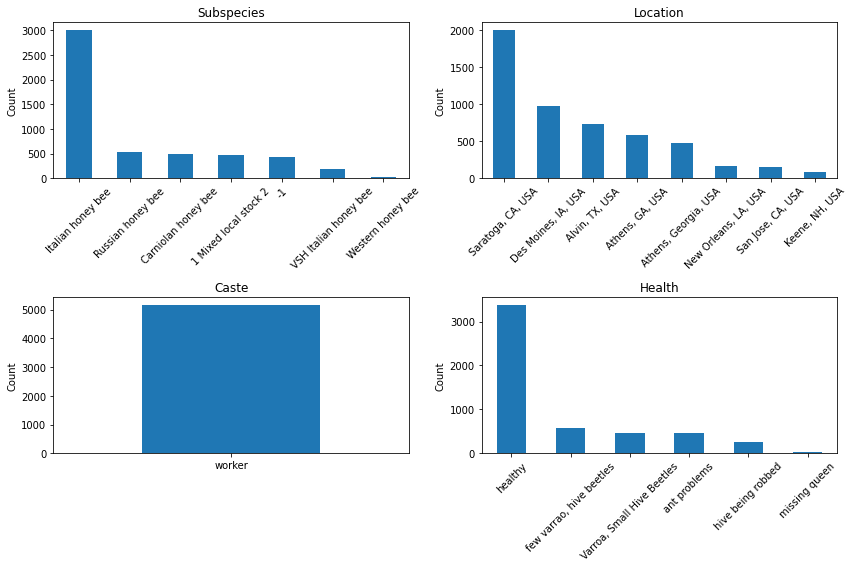

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

bee_df.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Subspecies')
labels = ax[0,0].get_xticklabels()
ax[0,0].set_xticklabels(labels, rotation=45)

bee_df.location.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('Location')
ax[0,1].set_ylabel('Count')
labels = ax[0,1].get_xticklabels()
ax[0,1].set_xticklabels(labels, rotation=45)

bee_df.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste')
ax[1,0].set_ylabel('Count')
labels = ax[1,0].get_xticklabels()
ax[1,0].set_xticklabels(labels, rotation=0)

bee_df.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Count')
labels = ax[1,1].get_xticklabels()
ax[1,1].set_xticklabels(labels, rotation=45)

fig.subplots_adjust(hspace=0.7)
fig.tight_layout()

plt.show()

The data is highly imbalanced in the two target categories, Health and Subspecies. This can be fixed in multiple ways. We will incorporate class weights into our models during training.

''

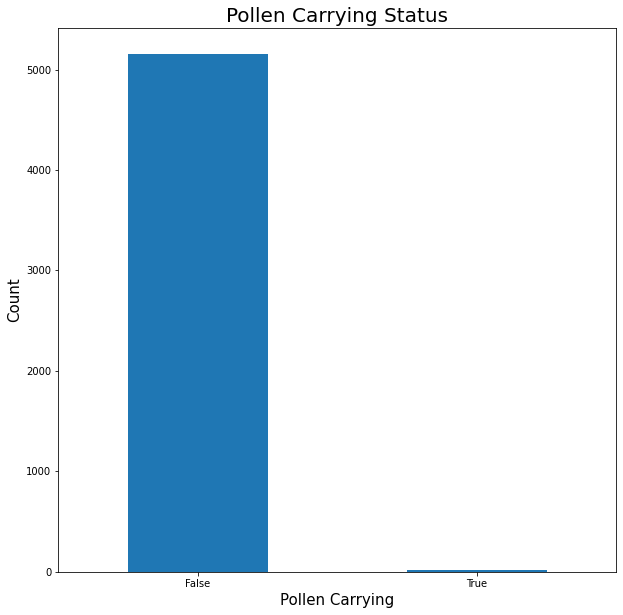

In [10]:
plt.figure(figsize=(10,10))
bee_df.pollen_carrying.value_counts().plot(kind='bar')
plt.title('Pollen Carrying Status', fontsize = 20)
plt.xlabel('Pollen Carrying', fontsize = 15)
plt.xticks(rotation = 0)
plt.ylabel('Count', fontsize = 15)

;

Since the pollen carrying status is extremely imbalanced, I will not be using this as a target.

In [11]:
# Combine 'Athens, GA' and 'Athens, Georgia, USA' as 'Athens, GA, USA'
bee_df = bee_df.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')

In [12]:
bee_df.subspecies.value_counts(normalize = True)

Italian honey bee        0.581593
Russian honey bee        0.101895
Carniolan honey bee      0.096868
1 Mixed local stock 2    0.091261
-1                       0.082753
VSH Italian honey bee    0.038476
Western honey bee        0.007154
Name: subspecies, dtype: float64

The subspecies of "-1" refers to unknown species, to be filled in when the authors of the dataset obtain more information. At this time, we will change the value to "Unknown".

In [13]:
bee_df['subspecies'] = ['Unknown' if i == '-1' else i for i in bee_df.subspecies]

In [14]:
bee_df.subspecies.value_counts()

Italian honey bee        3008
Russian honey bee         527
Carniolan honey bee       501
1 Mixed local stock 2     472
Unknown                   428
VSH Italian honey bee     199
Western honey bee          37
Name: subspecies, dtype: int64

## Examining Images and Image Data

In [15]:
# Check number of image files
image_files = list(os.listdir(IMAGE_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5172


In [16]:
# Check that each image has a matching data entry
file_names = list(bee_df['file'])
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 5172


In [17]:
# Define a function to read the image dimensions
def read_image_sizes(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    return list(image.shape)

In [18]:
# Stack dimensions of successive images, test on a small number
np.stack([read_image_sizes(filename) for filename in bee_df['file'][:10]])

array([[115, 164,   3],
       [201,  90,   3],
       [132, 167,   3],
       [134,  97,   3],
       [147, 106,   3],
       [194, 135,   3],
       [159, 170,   3],
       [132,  95,   3],
       [126, 190,   3],
       [156, 189,   3]])

In [19]:
# Append Width, Height, and Color channel data to original dataframe
m = np.stack(bee_df['file'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['width','height','color'])
bee_df = pd.concat([bee_df,df],axis=1, sort=False)

#### Plotting image height and width distributions

''

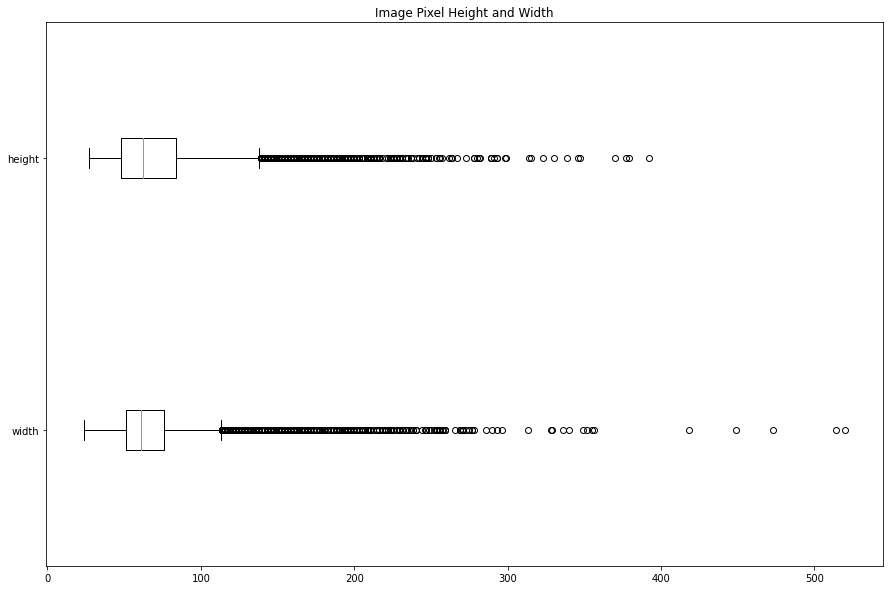

In [20]:
plt.figure(figsize = (15,10))
plt.boxplot([bee_df.width, bee_df.height], labels = ['width', 'height'], vert = False)

plt.title('Image Pixel Height and Width')
;

 - The outliers are all above 100 px in both height and width, so we will scale images to 100x100 px. We will be upscaling smaller images in order to accentuate the bee in the image and to standardize with other images.

### Examining Image Counts

In [21]:
# Group by zipcode/location and check how many images were taken at each location
tmp = bee_df.groupby(['zip code'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

,zip code,location,Images
0,3431,"Keene, NH, USA",92
1,30607,"Athens, GA, USA",1051
2,50315,"Des Moines, IA, USA",973
3,70115,"New Orleans, LA, USA",170
4,77511,"Alvin, TX, USA",737
5,95070,"Saratoga, CA, USA",2000
6,95124,"San Jose, CA, USA",149


''

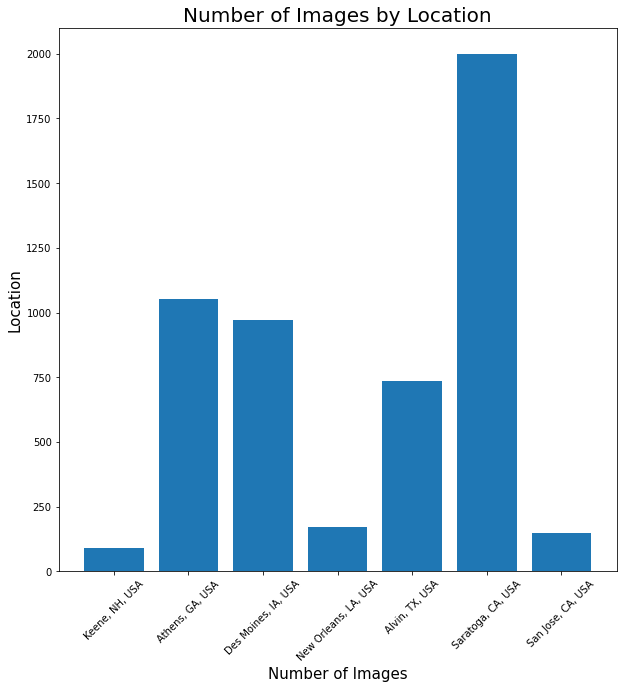

In [22]:
plt.figure(figsize=(10,10))
plt.bar(df.location, df.Images)
plt.title('Number of Images by Location', fontsize = 20)
plt.xticks(rotation=45)
plt.xlabel('Number of Images', fontsize = 15)
plt.ylabel('Location', fontsize = 15)
;

### Examining The Times Photos Were Captured

In [23]:
bee_df['date_time'] = pd.to_datetime(bee_df['date'] + ' ' + bee_df['time'])
bee_df["year"] = bee_df['date_time'].dt.year
bee_df["month"] = bee_df['date_time'].dt.month
bee_df["day"] = bee_df['date_time'].dt.day
bee_df["hour"] = bee_df['date_time'].dt.hour
bee_df["minute"] = bee_df['date_time'].dt.minute

In [24]:
bee_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,width,height,color,date_time,year,month,day,hour,minute
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,Unknown,hive being robbed,False,worker,115,164,3,2018-08-28 16:07:00,2018,8,28,16,7
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,Unknown,hive being robbed,False,worker,201,90,3,2018-08-28 16:07:00,2018,8,28,16,7
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,Unknown,hive being robbed,False,worker,132,167,3,2018-08-28 16:07:00,2018,8,28,16,7
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,Unknown,hive being robbed,False,worker,134,97,3,2018-08-28 16:07:00,2018,8,28,16,7
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,Unknown,hive being robbed,False,worker,147,106,3,2018-08-28 16:07:00,2018,8,28,16,7


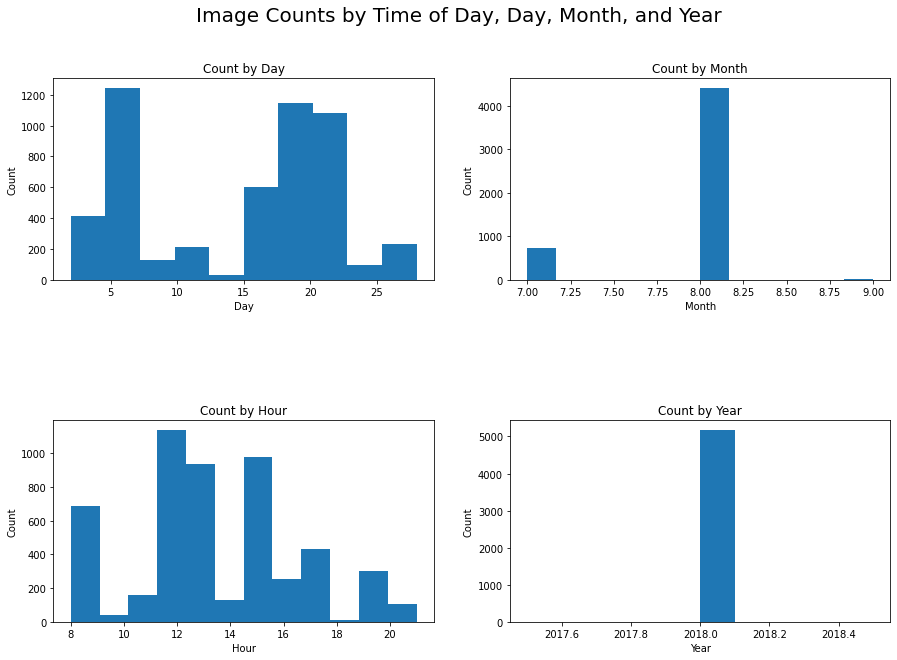

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plt.suptitle('Image Counts by Time of Day, Day, Month, and Year', fontsize = 20)

bee_df.day.plot(kind='hist',ax=ax[0, 0], bins = 10)
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Count by Day')
ax[0,0].set_xlabel('Day')

bee_df.month.plot(kind='hist', ax=ax[0, 1], bins = 12)
ax[0,1].set_title('Count by Month')
ax[0,1].set_ylabel('Count')
ax[0,1].set_xlabel('Month')

bee_df.hour.plot(kind='hist', ax=ax[1, 0], bins = 12)
ax[1,0].set_title('Count by Hour')
ax[1,0].set_ylabel('Count')
ax[1,0].set_xlabel('Hour')

bee_df.year.plot(kind='hist', ax=ax[1,1])
ax[1,1].set_title('Count by Year')
ax[1,1].set_ylabel('Count')
ax[1,1].set_xlabel('Year')


fig.subplots_adjust(hspace=0.7)


plt.show()

In [26]:
tmp = bee_df.groupby(['date_time'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df[:10]

,date_time,location,Images
0,2018-07-02 13:57:00,"Saratoga, CA, USA",114
1,2018-07-02 15:30:00,"Saratoga, CA, USA",248
2,2018-07-03 16:10:00,"Saratoga, CA, USA",50
3,2018-07-07 12:56:00,"Saratoga, CA, USA",303
4,2018-07-07 14:00:00,"Saratoga, CA, USA",3
5,2018-07-07 14:35:00,"Saratoga, CA, USA",15
6,2018-08-06 11:25:00,"Saratoga, CA, USA",18
7,2018-08-06 13:19:00,"Saratoga, CA, USA",460
8,2018-08-06 13:21:00,"Saratoga, CA, USA",124
9,2018-08-06 14:48:00,"Saratoga, CA, USA",19


''

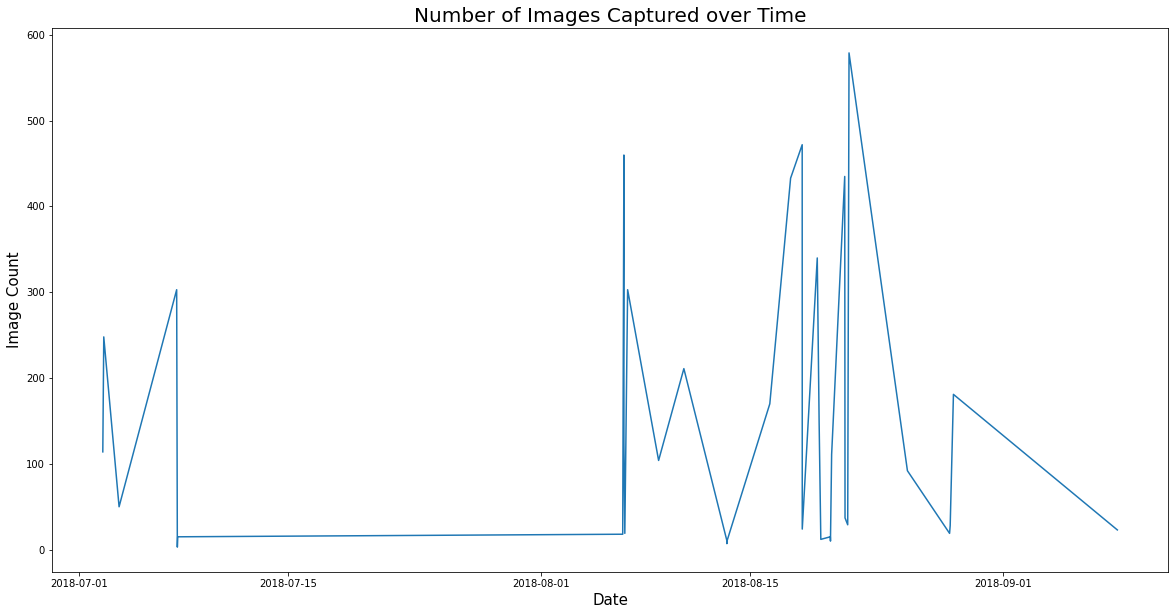

In [27]:
plt.figure(figsize=(20,10))
plt.plot(df['date_time'], df['Images'])

plt.title('Number of Images Captured over Time', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Image Count', fontsize = 15)
;

### Plotting Example Images

In [28]:
filenames = bee_df['file']
filenames[:10]

0    041_066.png
1    041_072.png
2    041_073.png
3    041_067.png
4    041_059.png
5    041_071.png
6    041_065.png
7    041_064.png
8    041_070.png
9    041_058.png
Name: file, dtype: object

In [29]:
bee_df.subspecies.value_counts().index

Index(['Italian honey bee', 'Russian honey bee', 'Carniolan honey bee',
       '1 Mixed local stock 2', 'Unknown', 'VSH Italian honey bee',
       'Western honey bee'],
      dtype='object')

#### Plotting Random Images

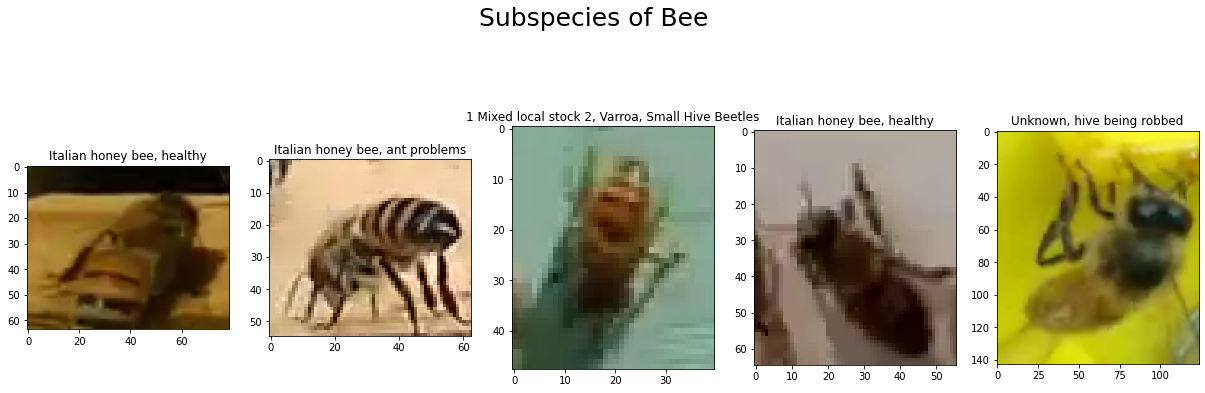

In [30]:
f, ax = plt.subplots(nrows=1,ncols=5, figsize=(21,7))
i = 0
for n in np.random.randint(low = 0, high = len(filenames), size = 5):
  image = Image.open(IMAGE_PATH+filenames[n])
  ax[i].imshow(image)
  health = bee_df['health'][n]
  subspecies = bee_df['subspecies'][n]
  ax[i].set_title(f'{subspecies}, {health}')
  i+=1

plt.suptitle("Subspecies of Bee", fontsize = 25)
plt.show()

#### Save Data to CSV

In [31]:
# Uncomment to over-write data
# bee_df.to_csv('/content/drive/MyDrive/Capstone/data/bee_data_w_image.csv')